# Result Analysis

In [127]:
import pandas as pd

def load_df(model_type):
    path = f"../data/dfs/{model_type}/ReferenceErrorDetection_data_with_prompt_results.pkl"
    df = pd.read_pickle(path)
    return df

In [128]:
def remove_json_colons(json_text):
    if json_text and json_text.startswith("```json") and json_text.rstrip().endswith("```"):
        return json_text[7:-3]
    return json_text

In [129]:
import json

# Add extra columns for the model classification label and explanation by extracting the information from the JSON
# If the JSON is misformed due to leading ```json and trailing ``` then remove them
# Make sure that correct label and model label are both lower case and do not end with d (unsubstaniate instead of unsubstantiated)
def reshape_model_classification(df):
    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            try:
                row['Model Classification'] = remove_json_colons(row['Model Classification'])
                model_classification = json.loads(row['Model Classification'])
                label = model_classification['label'].lower()
                df.at[row.name, 'Model Classification Label'] = label if not label.endswith('d') else label[:-1]
                df.at[row.name, 'Model Classification Explanation'] = model_classification['explanation']
            except json.JSONDecodeError as e:
                print(f"Row {index} Model Classification could not be decoded: {e}")
                print(row['Model Classification'])
        else:
            df.at[row.name, 'Model Classification Label'] = None
            df.at[row.name, 'Model Classification Explanation'] = None
        df.at[row.name, 'Label'] = df.at[row.name, 'Label'].lower()
    return df

In [130]:
def eval_predictions_all_labels(df, include_not_originally_downloaded=True):
    total = 0
    correct = 0
    false_predictions = 0

    # What was the target label and what did the model predict (first hierarchy is target label, second is model label)
    type_false_predictions = {
        'unsubstantiate': {
            'partially substantiate': 0,
            'fully substantiate': 0
        },
        'partially substantiate': {
            'unsubstantiate': 0,
            'fully substantiate': 0
        },
        'fully substantiate': {
            'unsubstantiate': 0,
            'partially substantiate': 0
        }
    }

    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            if include_not_originally_downloaded or row['Reference Article PDF Available'] == 'Yes':
                total += 1
                target_label = row['Label']
                model_label = row['Model Classification Label']

                if target_label == model_label:
                    correct += 1
                elif model_label not in ['unsubstantiate', 'partially substantiate', 'fully substantiate']:
                    false_predictions += 1
                    print(f"Row {index} Model Classification Label is not a valid label: {model_label}")
                else:
                    false_predictions += 1
                    type_false_predictions[target_label][model_label] += 1
    
    evaluation_results = {
        'accuracy': round(correct / total, 4),
        'total': total,
        'correct': correct,
        'false_predictions': false_predictions,
        'type_false_predictions': type_false_predictions
    }

    return evaluation_results

In [131]:
def replace_substantiate_label(label):
    if label in ['partially substantiate', 'fully substantiate']:
        label = 'substantiate'
    return label

In [132]:
def eval_predictions_two_labels(df, include_not_originally_downloaded=True):
    total = 0
    correct = 0
    false_predictions = 0
    false_positives = 0
    false_negatives = 0

    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            if include_not_originally_downloaded or row['Reference Article PDF Available'] == 'Yes':
                total += 1
                target_label = replace_substantiate_label(row['Label'])
                model_label = replace_substantiate_label(row['Model Classification Label'])

                if target_label == model_label:
                    correct += 1
                else:
                    false_predictions += 1
                    if model_label not in ['unsubstantiate', 'substantiate']:
                        print(f"Row {index} Model Classification Label is not a valid label: {model_label}")
                    elif target_label == 'unsubstantiate' and model_label == 'substantiate':
                        false_positives += 1
                    elif target_label == 'substantiate' and model_label == 'unsubstantiate':
                        false_negatives += 1
    
    evaluation_results = {
        'accuracy': round(correct / total, 4),
        'total': total,
        'correct': correct,
        'false_predictions': false_predictions,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

    return evaluation_results

## Gather Results: Model Comparison

In [133]:
all_results = {}

In [134]:
def gather_results(model_type):
    df = load_df(model_type)
    df = reshape_model_classification(df)
    
    results_all_labels = eval_predictions_all_labels(df)
    results_all_labels_exlude_not_available = eval_predictions_all_labels(df, False)
    results_two_labels = eval_predictions_two_labels(df)
    results_two_labels_exlude_not_available = eval_predictions_two_labels(df, False)

    results = {
        'all_labels': results_all_labels,
        'all_labels_exclude_not_available': results_all_labels_exlude_not_available,
        'two_labels': results_two_labels,
        'two_labels_exclude_not_available': results_two_labels_exlude_not_available
    }
    return results

### Small GROBID Model
- PDF text extracted with smaller GROBID model 
- full text from TEI document directly fed into index generation 
- Model temperature set to 0 (for top 3 excerpts retrieval and for classification via model prompting)
- Used embedding for index: text-embedding-3-small
- Used model for prompting: gpt-3.5-turbo-0125

In [135]:
model_type = "small_model"
all_results[model_type] = gather_results(model_type)

### Full GROBID Model
- PDF text extracted with full GROBID model
- full text from TEI document directly fed into index generation 
- Model temperature set to 0 (for top 3 excerpts retrieval and for classification via model prompting)
- Used embedding for index: text-embedding-3-small
- Used model for prompting: gpt-3.5-turbo-0125

In [136]:
model_type = "full_model"
all_results[model_type] = gather_results(model_type)

### Full GROBID Model + TEI document text refactoring
- PDF text extracted with full GROBID model
- Only text from body of papers (actual content) extracted from TEI documents
- Model temperature set to 0 (for top 3 excerpts retrieval and for classification via model prompting)
- Used embedding for index: text-embedding-3-small
- Used model for prompting: gpt-3.5-turbo-0125

In [137]:
model_type = "full_model_texts"
all_results[model_type] = gather_results(model_type)

In [ ]:
import json

with open("../data/all_results.json", "w") as json_file:
    json.dump(all_results, json_file, indent=4)

## Visualize Results: Model Comparison

In [140]:
import json

with open("../data/all_results.json", "r") as json_file:
    all_results = json.load(json_file)

In [141]:
all_results

{'small_model': {'all_labels': {'accuracy': 0.4939,
   'total': 247,
   'correct': 122,
   'false_predictions': 125,
   'type_false_predictions': {'unsubstantiate': {'partially substantiate': 19,
     'fully substantiate': 19},
    'partially substantiate': {'unsubstantiate': 3, 'fully substantiate': 6},
    'fully substantiate': {'unsubstantiate': 11,
     'partially substantiate': 67}}},
  'all_labels_exclude_not_available': {'accuracy': 0.5,
   'total': 244,
   'correct': 122,
   'false_predictions': 122,
   'type_false_predictions': {'unsubstantiate': {'partially substantiate': 18,
     'fully substantiate': 19},
    'partially substantiate': {'unsubstantiate': 3, 'fully substantiate': 6},
    'fully substantiate': {'unsubstantiate': 10,
     'partially substantiate': 66}}},
  'two_labels': {'accuracy': 0.7895,
   'total': 247,
   'correct': 195,
   'false_predictions': 52,
   'false_positives': 38,
   'false_negatives': 14},
  'two_labels_exclude_not_available': {'accuracy': 0.795

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Define consistent colors for each model
MODEL_COLORS = {
    'small_model': 'blue',
    'full_model': 'green',
    'full_model_texts': 'red'
}

In [193]:
def plot_accuracy_comparison(all_results):
    labels = ['All Labels', 'All Labels (Excl. NA)', 'Two Labels', 'Two Labels (Excl. NA)']
    model_names = list(all_results.keys())

    data = {
        model: [
            all_results[model]['all_labels']['accuracy'],
            all_results[model]['all_labels_exclude_not_available']['accuracy'],
            all_results[model]['two_labels']['accuracy'],
            all_results[model]['two_labels_exclude_not_available']['accuracy']
        ] for model in model_names
    }

    x = np.arange(len(labels))
    bar_width = 0.25

    plt.figure(figsize=(10, 6))

    for i, model in enumerate(model_names):
        plt.bar(x + i * bar_width, data[model], bar_width, label=model, color=MODEL_COLORS[model])

    plt.xticks(x + bar_width, labels)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Across Labels')
    plt.legend()
    plt.show()

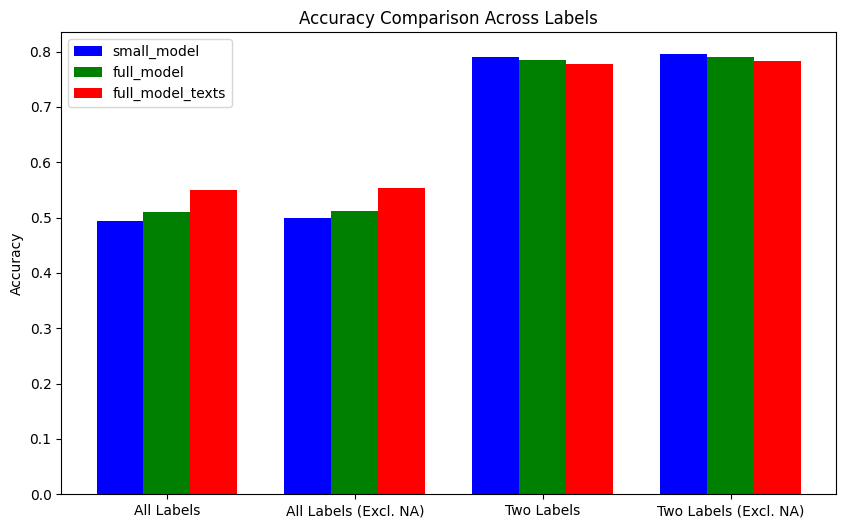

In [194]:
plot_accuracy_comparison(all_results)

In [191]:
import matplotlib.colors as mcolors

def adjust_color(color, factor):
    """ Adjusts a color brightness by a given factor. Factor > 1 lightens, factor < 1 darkens. """
    rgb = mcolors.to_rgb(color)
    adjusted_rgb = tuple(min(max(c * factor, 0), 1) for c in rgb)
    return mcolors.to_hex(adjusted_rgb)

def plot_false_predictions_by_type(all_results):
    labels = ['unsubstantiate', 'partially substantiate', 'fully substantiate']
    model_names = list(all_results.keys())

    # Define color variations
    model_color_variants = {
        model: {
            'unsubstantiate': MODEL_COLORS[model],  # Base color but transparent
            'partially substantiate': MODEL_COLORS[model],  # Base color (full opacity)
            'fully substantiate': adjust_color(MODEL_COLORS[model], 0.5)  # 50% darker
        }
        for model in model_names
    }

    misclassification_data = {model: {label: {} for label in labels} for model in model_names}

    for model in model_names:
        false_predictions = all_results[model]['all_labels']['type_false_predictions']
        for label in labels:
            misclassification_data[model][label] = false_predictions.get(label, {})

    x = np.arange(len(labels))
    bar_width = 0.25

    plt.figure(figsize=(12, 6))

    for i, model in enumerate(model_names):
        bottom_values = np.zeros(len(labels))  # Stack bars on top of each other
        for misclassified_as in labels:
            values = [misclassification_data[model][label].get(misclassified_as, 0) for label in labels]
            plt.bar(
                x + i * bar_width,
                values,
                bar_width,
                bottom=bottom_values,
                label=f"{model}: {misclassified_as}",
                color=model_color_variants[model][misclassified_as],
                alpha=0.4 if misclassified_as == 'unsubstantiate' else 1.0  # Transparency only for "unsubstantiate"
            )
            bottom_values += np.array(values)

    plt.xticks(x + bar_width, labels)
    plt.xlabel('Target Label')
    plt.ylabel('Number False Predictions')
    plt.ylim(0, max(bottom_values) * 1.3)
    plt.title('False Predictions Breakdown by Type (All labels, including NA)')
    plt.legend()
    plt.show()


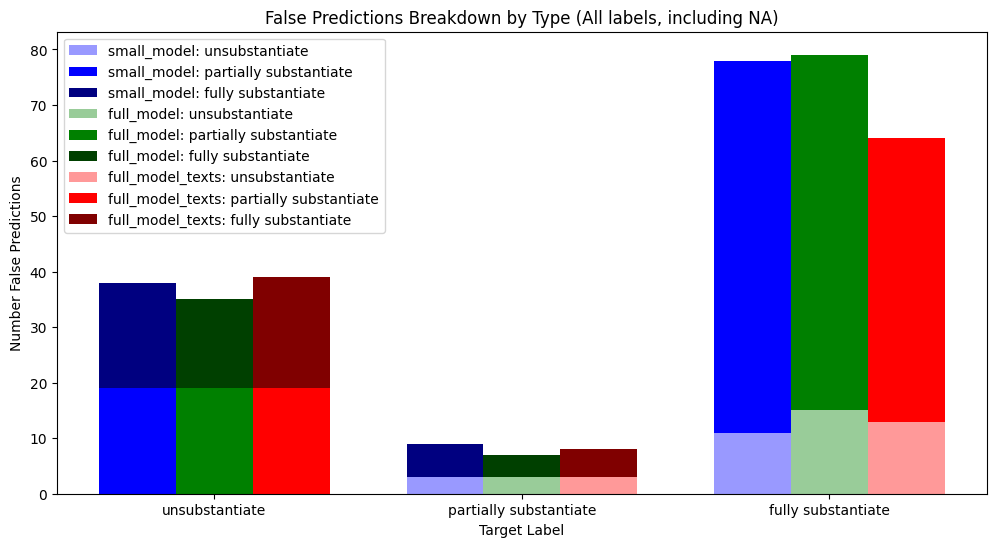

In [192]:
plot_false_predictions_by_type(all_results)

In [189]:
def plot_false_positives_vs_negatives(all_results):
    labels = ['Correct Predictions', 'False Positives', 'False Negatives']
    model_names = list(all_results.keys())

    data = {
        model: [
            all_results[model]['two_labels']['correct'],  # Added correct predictions
            all_results[model]['two_labels']['false_positives'],
            all_results[model]['two_labels']['false_negatives']
        ] for model in model_names
    }

    x = np.arange(len(labels))
    bar_width = 0.25

    plt.figure(figsize=(8, 5))

    for i, model in enumerate(model_names):
        plt.bar(x + i * bar_width, data[model], bar_width, label=model, color=MODEL_COLORS[model])

    plt.xticks(x + bar_width, labels)
    plt.ylabel('Count')
    plt.title('Two Labels: Correct Predictions vs. False Positives vs. False Negatives')
    plt.legend()
    plt.show()

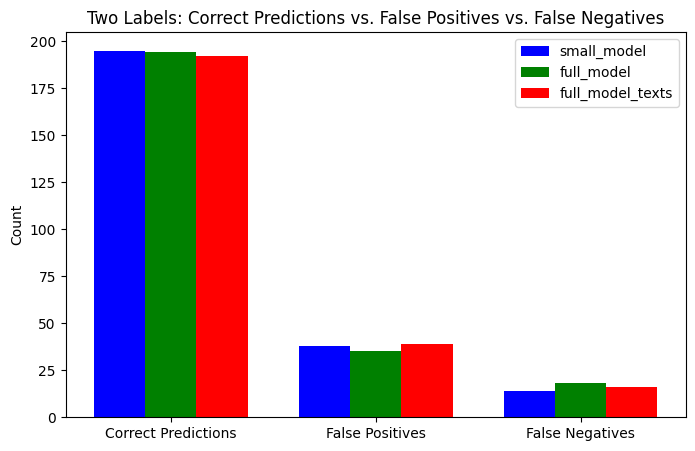

In [190]:
plot_false_positives_vs_negatives(all_results)